# Vision Fine-tuning  - Maths OCR

- https://docs.unsloth.ai/basics/vision-fine-tuning
- https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing

In [2]:
from unsloth import FastVisionModel, is_bf16_supported # FastLanguageModel for LLMs
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import TextStreamer

from datasets import load_dataset

# To render latex in jupyter
from IPython.display import display, Math, Latex

## Load the model

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [3]:
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
model, tokenizer = FastVisionModel.from_pretrained(
    # More models at https://huggingface.co/unsloth
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.3.9: Fast Qwen2_Vl patching. Transformers: 4.49.0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.visual` require gradients


## Load the data

We'll be using a sampled dataset of handwritten maths formulas. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it. This can be very useful for complex formulas.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [5]:
dataset = load_dataset("unsloth/LaTeX_OCR", split="train")
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

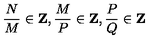

In [6]:
dataset[0]["image"]

In [7]:
# We can render the LaTeX in the browser directly!
latex = dataset[0]["text"]
print(latex)
display(Math(latex))

{ \frac { N } { M } } \in { \bf Z } , { \frac { M } { P } } \in { \bf Z } , { \frac { P } { Q } } \in { \bf Z }


<IPython.core.display.Math object>

### Format the input for the model

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
    {
        "role": "user",
        "content": [
            {"type": "text",  "text": Q},
            {"type": "image", "image": image}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text",  "text": A}
        ]
    },
]
```

In [8]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        { 
            "role": "user",
            "content" : [
                {"type" : "text",  "text"  : instruction},
                {"type" : "image", "image" : sample["image"]}
            ]
        },
        {
            "role" : "assistant",
            "content" : [
                {"type" : "text",  "text"  : sample["text"]}
            ]
        },
    ]
    return { "messages" : conversation }

Let's convert the dataset into the "correct" format for finetuning:

In [9]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [11]:
print(
    tokenizer.apply_chat_template(converted_dataset[0]["messages"], tokenize=False)
)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Write the LaTeX representation for this image.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant
{ \frac { N } { M } } \in { \bf Z } , { \frac { M } { P } } \in { \bf Z } , { \frac { P } { Q } } \in { \bf Z }<|im_end|>



## Inference before finetuning

Let's first see before we do any finetuning what the model outputs for the first example!

In [12]:
FastVisionModel.for_inference(model) # Enable for inference!
print("Model is ready for inference!")

Model is ready for inference!


In [14]:
image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {
        "role": "user", "content": [
            {"type": "text", "text": instruction},
            {"type": "image"}
        ]
    }
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [15]:
print(input_text)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Write the LaTeX representation for this image.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



In [16]:
outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True, temperature=0.1, min_p=0.1)

In [17]:
# Decode the output, from ids to text
preds = tokenizer.batch_decode(outputs)
pred = preds[0]  # We sent just one example, get the first one
# from the generated text, cut the prompt
prompt_ids = inputs["input_ids"][0]  # We sent just one example, get the first one
prompt_len = len(prompt_ids)
pred = pred[prompt_len:]
# get all between "$$"" and "$$"
latex = pred.split("$$")[1]
display(Math(latex))

<IPython.core.display.Math object>

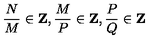

In [18]:
image

## Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 30 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [78]:
FastVisionModel.for_training(model) # Enable for training!
print("Model is ready for training!")

Model is ready for training!


In [79]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [80]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936/5,063,203,328 (1.00% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.177700
2,1.323700
3,1.449600
4,1.054600
5,0.995200
6,0.973300
7,0.771200
8,0.514500
9,0.349700
10,0.383300


### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [81]:
model.save_pretrained("handtolatext-lora_model") # Local saving
tokenizer.save_pretrained("handtolatext-lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

## Inference after finetuning

Let's see after finetuning what the model outputs for the first example!

In [82]:
FastVisionModel.for_inference(model) # Enable for inference!
print("Model is ready for inference!")

Model is ready for inference!


In [103]:
image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {
        "role": "user", "content": [
            {"type": "text", "text": instruction},
            {"type": "image"}
        ]
    }
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [126]:
outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True, temperature=0.1, min_p=0.1)
# Decode the output, from ids to text
preds = tokenizer.batch_decode(outputs)
pred = preds[0]  # We sent just one example, get the first one

In [127]:
print(pred)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Write the LaTeX representation for this image.<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant
\frac { N } { M } \in \mathbf { Z } , \frac { M } { P } \in \mathbf { Z } , \frac { P } { Q } \in \mathbf { Q }<|im_end|>


In [128]:
# The output follows the training format
# We need to cut from last "<|im_start|>assistant\n" to the end
pred = pred.split("<|im_start|>assistant\n")[1]
# And remove the last "<|im_end|>"
# The training dataset don't use the $$ delimiters
latex = pred.split("<|im_end|>")[0]
display(Math(latex))

<IPython.core.display.Math object>

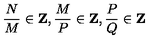

In [100]:
image